### 1. 不使用框架搭建CNN

#### 1.1 引入库

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload

%autoreload 2

np.random.seed(1)

#### 1.2 zero padding

In [2]:
def zero_pad(X,pad):
    """
    参数：
        X - 图像数据集，维度为（样本数，图像高度，图像宽度，通道数）
        pad - padding的单元数
    返回：
        X_paded - padding后的图像数据集 
    """
    X_paded = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values=(0,0))
    return X_paded

In [3]:
# 测试zero_pad
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)

print("x.shape = "+str(x.shape))
print("x_paded.shape = "+str(x_paded.shape))

x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)


#### 1.3 单步卷积

In [6]:
def conv_single_step(a_slice_prev,W,b):
    """
    参数：
        W - 卷积核
        a_slice_prev - 与卷积核size相同的图像的一部分
        b - bias
    返回：
        Z - 进行一次单步卷积的结果
    """
    temp = np.multiply(a_slice_prev,W)+b
    Z = np.sum(temp)
    
    return Z

In [7]:
# 测试conv_single_step
np.random.seed(1)

a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)
print("Z = "+str(Z))

Z = -23.16021220252078


#### 1.4 卷积层前向传播

In [12]:
def conv_forward(A_prev,W,b,hparameters):
    """
    参数：
        A_prev - (m,n_h_prev,n_w_prev,n_c_prev)维度
        W - (f,f,n_c_prev,n_c)维度
        b - bias (1,1,1)
        hparameters - 包含stride 和 pad参数的字典
    返回：
        Z - 卷积+bias后的输出
        cache - 中间值 bp时会用到
    """
    # 获取输入的size
    (m,n_h_prev,n_w_prev,n_c_prev) = A_prev.shape
    # 获取卷积核size
    (f,f,n_c_prev,n_c) = W.shape
    
    # 获取stride和pad超参数
    s = hparameters["stride"]
    p = hparameters["pad"]
    
    # 初始化输出Z
    n_h = int((n_h_prev+2*p-f)/s)+1
    n_w = int((n_w_prev+2*p-f)/s)+1
    Z = np.zeros((m,n_h,n_w,n_c))
    
    # padding
    A_prev_padding = zero_pad(A_prev,p)
    
    # 计算Z
    for i in range(m):
        # 取出第i个图像
        a_prev_padding = A_prev_padding[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    # 获得a_slice_prev
                    vertical_start = h*s
                    vertical_end = vertical_start + f
                    horizontal_start = w*s
                    horizontal_end = horizontal_start + f
                    a_slice_prev = a_prev_padding[vertical_start:vertical_end,horizontal_start:horizontal_end,:]
                    
                    # single conv
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
    cache = (A_prev,W,b,hparameters)
    return Z,cache

In [13]:
# 测试conv_forward
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad":2,"stride":1}
Z,cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = "+str(np.mean(Z)))
print("cache_conv[0][1][2][3] = "+str(cache_conv[0][1][2][3]))

np.mean(Z) = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


#### 1.5 池化层前向传播
池化层有两种模式：一是max pooling，二是average pooling。

In [12]:
def pool_forward(A_prev,hparameters,mode="max"):
    """
    参数：
        A_prev - 图像数据 维度为(m,n_h_prev,n_w_prev,n_c_prev)
        hparameters - 包含stride 和 f的字典
        mode - "max" or "average"
    返回：
        A - 输出 维度为(m,n_h,n_w,n_c)
        cache - 中间值 用于反向传播的计算
    """
    # 获取A_prev 信息
    (m,n_h_prev,n_w_prev,n_c_prev) = A_prev.shape
    
    # 获取超参数信息
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # 得到输出的size
    n_h = int((n_h_prev-f)/stride)+1
    n_w = int((n_w_prev-f)/stride)+1
    n_c = n_c_prev
    
    # 初始化输出
    A = np.zeros((m,n_h,n_w,n_c))
    
    
    
    # 计算pooling结果
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range (n_c):
                    # 确定slice的位置
                    vertical_start = h*stride
                    vertical_end = vertical_start + f
                    horizontal_start = w*stride
                    horizontal_end = horizontal_start + f
                    
                    a_prev_slice = a_prev[vertical_start:vertical_end,horizontal_start:horizontal_end,c]
                    
                    if mode == "max":
                        A[i,h,w,c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i,h,w,c] = np.mean(a_prev_slice)
    cache = (A_prev,hparameters)
    return A,cache

In [14]:
# 测试pool_forward
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4,"stride":1}

A,cache = pool_forward(A_prev,hparameters,mode="max")
print("Max mode")
print("A = "+str(A))
print("================")
A,cache = pool_forward(A_prev,hparameters,mode="average")
print("Average mode")
print("A = "+str(A))

Max mode
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
Average mode
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


### 2. 利用Tensorflow框架构建CNN模型
#### 2.1 引入库

In [17]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

y = [1]


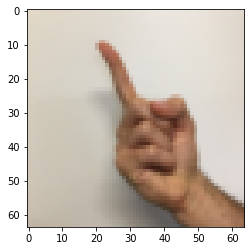

In [21]:
# 观察数据集的图片
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes = cnn_utils.load_dataset()
index = 11
plt.imshow(X_train_orig[index])
print("y = "+str(Y_train_orig[:,index]))

In [22]:
X_train = X_train_orig / 255
X_test = X_test_orig / 255
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig,6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig,6).T
conv_layers = {}

print("X_train.shape : "+str(X_train.shape))
print("X_test.shape : "+str(X_test.shape))
print("Y_train.shape : "+str(Y_train.shape))
print("Y_test.shape : "+str(Y_train.shape))

X_train.shape : (1080, 64, 64, 3)
X_test.shape : (120, 64, 64, 3)
Y_train.shape : (1080, 6)
Y_test.shape : (1080, 6)


#### 2.2 创建占位符Placeholders
需要创建占位符X和Y，以便在计算图构建完成后向其中喂数据

In [23]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    return X,Y

In [24]:
# 测试create_placeholders
X,Y = create_placeholders(64,64,3,6)
print("X = "+str(X))
print("Y = "+str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


#### 2.3 初始化参数
使用Tensorflow构建CNN时，只需要对卷积核进行参数的初始化即可。偏置b和全连接层参数的初始化由框架自动完成。

In [29]:
def init_params():
    """
    初始化的参数：
        W1 : [4,4,3,8]
        W2: [2,2,8,16]
    """
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    params = {
        "W1":W1,
        "W2":W2
    }
    return params

In [30]:
# 测试init_params
tf.reset_default_graph()
with tf.Session() as session:
    params = init_params()
    W1 = params["W1"]
    W2 = params["W2"]
    init = tf.global_variables_initializer()
    session.run(init)
    print("W1 = "+str(W1.eval()[1,1,1]))
    print("W2 = "+str(W2.eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
